In [1]:
import pandas as pd
import sqlite3
import fato_db
import smartTag
import indexs
import random
import matplotlib.pyplot as plt
import numpy as np
conn = sqlite3.connect("sample_db.db")
df = pd.read_sql_query("\
    SELECT s.name, s.path, s.extension, s.disk, ifnull(t.name, 'NoTag') as tag \
    FROM fato as f INNER JOIN sample as s on f.id_sample = s.id_sample LEFT JOIN tag as t on f.id_tag = t.id_tag", conn)
df.head(10)

,name,path,extension,disk,tag
0,FLGM_140_Drums_Full_27.wav,/Users/luisclaudio/Downloads/Groove Metal/FLGM...,wav,mac,Strings
1,FLGM_140_Drums_Full_26.wav,/Users/luisclaudio/Downloads/Groove Metal/FLGM...,wav,mac,Drums
2,FLGM_140_Drums_Full_32.wav,/Users/luisclaudio/Downloads/Groove Metal/FLGM...,wav,mac,FX
3,FLGM_140_Drums_Full_18.wav,/Users/luisclaudio/Downloads/Groove Metal/FLGM...,wav,mac,Strings
4,FLGM_140_Drums_Full_8.wav,/Users/luisclaudio/Downloads/Groove Metal/FLGM...,wav,mac,FX
5,FLGM_140_Drums_Full_24.wav,/Users/luisclaudio/Downloads/Groove Metal/FLGM...,wav,mac,FX
6,FLGM_140_Drums_Full_30.wav,/Users/luisclaudio/Downloads/Groove Metal/FLGM...,wav,mac,Drums
7,FLGM_140_Drums_Full_31.wav,/Users/luisclaudio/Downloads/Groove Metal/FLGM...,wav,mac,Strings
8,FLGM_140_Drums_Full_25.wav,/Users/luisclaudio/Downloads/Groove Metal/FLGM...,wav,mac,Drums
9,FLGM_140_Drums_Full_9.wav,/Users/luisclaudio/Downloads/Groove Metal/FLGM...,wav,mac,Cymbals


In [2]:
#- Total de samples
df_qtd_samples = pd.read_sql_query("select count(1) as qtd_samples from sample", conn)
df_qtd_samples

,qtd_samples
0,1597


In [3]:
#- Total de tags
df_qtd_tags = pd.read_sql_query("select distinct count(name) as qtd_tag from tag", conn)
df_qtd_tags

,qtd_tag
0,392


In [54]:
def saveTableCsv(df, file_name):
    df.to_csv('reportPic/' + file_name+'.csv', index = None, header=True)

In [5]:
def plotBarGraph(df, df_x, df_y, x_label, y_label, graph_title, file_name):
    # this is for plotting purpose
    fig, ax = plt.subplots(figsize=(18,5))
    index = np.arange(len(df_x))
    plt.bar(df_x, df_y)
    plt.xlabel(x_label, fontsize=5)
    plt.ylabel(y_label, fontsize=5)
    plt.xticks(index, fontsize=5, rotation=30)
    plt.title(graph_title)
    plt.figure(figsize=(20,20))
    fig.savefig("reportPic/" + file_name, bbox_inches='tight',pad_inches=0.1)

    plt.show()
    
    df.to_csv('reportPic/' + file_name, index = None, header=True)
    return

ValueError: Format 'csv' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff)

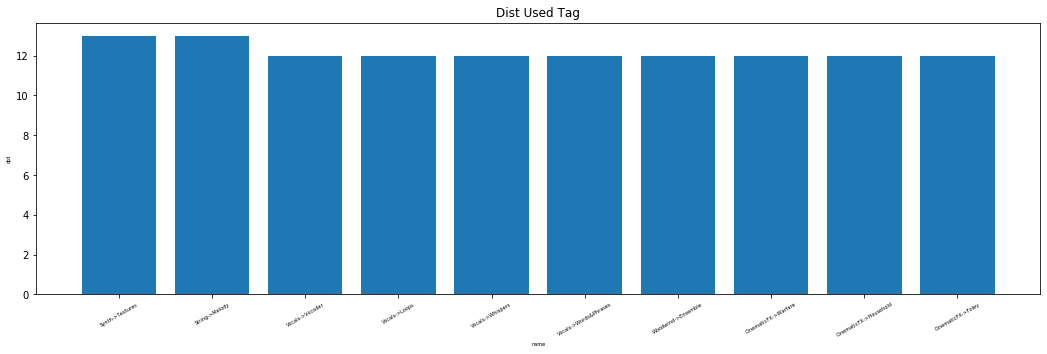

<Figure size 1440x1440 with 0 Axes>

In [6]:
#- Distribuição das tags (mais/menos usadas)
def distUsedTag():
    df = pd.read_sql_query("\
        SELECT t.name, count(f.id_tag) as qtd \
        FROM fato as f LEFT JOIN tag as t on f.id_tag = t.id_tag \
        group by f.id_tag \
        order by qtd DESC", conn)
    return df
df = distUsedTag().head(50).tail(10)
plotBarGraph(df, df.name, df.qtd, 'name', 'qtd', 'Dist Used Tag', 'distUsedTag.csv')
print(df.head())

ValueError: Format 'csv' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff)

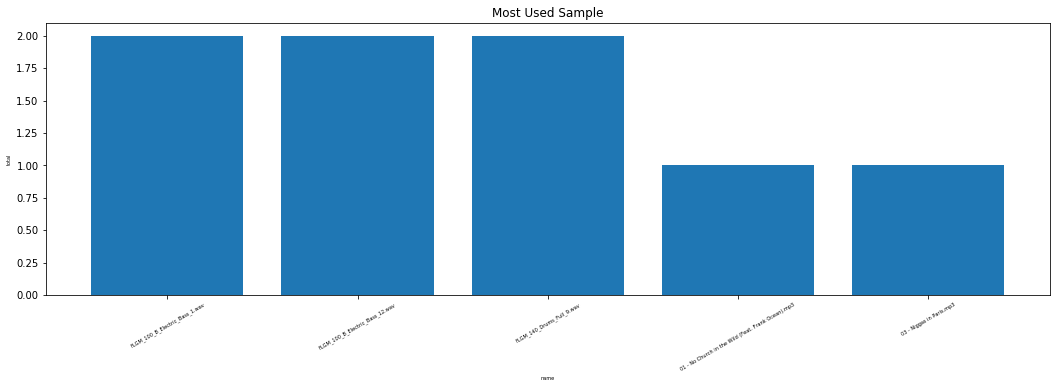

<Figure size 1440x1440 with 0 Axes>

In [7]:
#- Tag usada por samples
def mostUsedSample():
    df = pd.read_sql_query("\
        SELECT s.name, count(t.id_tag) as total \
        FROM fato as f LEFT JOIN tag as t on f.id_tag = t.id_tag \
        left join sample as s on f.id_sample = s.id_sample \
        where s.name is not null \
        group by s.id_sample, t.id_tag \
        ORDER by total DESC, s.name", conn)
    return df
df = mostUsedSample().head()
plotBarGraph(df, df.name, df.total, 'name', 'total', 'Most Used Sample', 'mostUsedSample.csv')
df.head(10)

In [8]:
#- Tags relacionadas
def defineRelationTag():
    lstRelationsScan = smartTag.scanTags('LevantamentoDeTagsPadrao/')
    lstRelationsScan = lstRelationsScan[1:]
    lstTagParent = []
    for i in lstRelationsScan:
        for k in i[1]:
            lstTagParent.append([i[0], k])
    return pd.DataFrame(lstTagParent, columns = ["father", "son" ])
    
defineRelationTag().head()

,father,son
0,FX,Transition
1,FX,Textures
2,FX,Impacts
3,FX,Noise
4,Drums,Cymbals


In [9]:
df = pd.read_sql_query("\
    SELECT s.name as sample_name, t.name as tag_name \
    FROM fato as f LEFT JOIN tag as t on f.id_tag = t.id_tag \
	left join sample as s on f.id_sample = s.id_sample \
	WHERE t.name like '%->%' \
	group by f.id_sample, f.id_tag \
    ORDER by s.name, t.name", conn)
df.head()




,sample_name,tag_name
0,None,Key->Synth
1,04 - Otis (Feat. Otis Redding).mp3,String->Ensemble
2,Bluezone-BC0214-explosion-001.wav,Brass->Stabs
3,FLGM_100_B_Electric_Bass_1.wav,CinematicFX->Animals
4,FLGM_100_B_Electric_Bass_11.wav,Brass->Stabs


In [10]:
def randomSyncTag():
    cur = conn.cursor()
    cur.execute("select id_tag from tag")
    rowsTag = cur.fetchall()
    cur.execute("select id_sample from sample")
    rowsSample = cur.fetchall()
    for i in range(500):
        rTag = random.choice(rowsTag)
        rSample = random.choice(rowsSample)
        #print(rTag, rSample)
        #fato_db.addIfNotExist(rSample[0], rTag[0])
        
def randomSyncTagRelatated():
    cur = conn.cursor()
    cur.execute("select id_tag from tag where name like ?", ('%->%',))
    rowsTag = cur.fetchall()
    cur.execute("select id_sample from sample")
    rowsSample = cur.fetchall()
    for i in range(50):
        rTag = random.choice(rowsTag)
        rSample = random.choice(rowsSample)
        #print(rTag, rSample)
        #fato_db.addIfNotExist(rSample[0], rTag[0])
randomSyncTag()


In [11]:
def distTagRelation():
    cur = conn.cursor()
    cur.execute("select id_tag from tag")
    rowsTag = cur.fetchall()
    cur.execute("\
    SELECT t.name as tag_name, count(f.id_tag) as qtd \
    FROM fato as f LEFT JOIN tag as t on f.id_tag = t.id_tag \
	left join sample as s on f.id_sample = s.id_sample \
	WHERE t.name like '%->%' \
	group by f.id_tag \
    ORDER by t.name ASC, qtd DESC")
    rowsAux = cur.fetchall()
    rows = []
    for i in rowsAux:
        sliptRow = i[0].split("->")
        rows.append([sliptRow[0],i[1]])
    df = pd.DataFrame(rows, columns = ['tag','count']).groupby(['tag']).sum()
    df.reset_index(level=0, inplace=True)
    return df
df = distTagRelation().head(15)
df.head()
#plotBarGraph(df, df.tag, df.count, 'tag', 'count', 'Dist Tag Relation', 'distTagRelation.csv')

,tag,count
0,Bass,124
1,Brass,76
2,CinematicFX,117
3,Drums,92
4,FX,44


In [12]:
def distSubTagRelation():
    cur = conn.cursor()
    cur.execute("select id_tag from tag")
    rowsTag = cur.fetchall()
    cur.execute("\
    SELECT t.name as tag_name, count(f.id_tag) as qtd \
    FROM fato as f LEFT JOIN tag as t on f.id_tag = t.id_tag \
	left join sample as s on f.id_sample = s.id_sample \
	WHERE t.name like '%->%' \
	group by f.id_tag \
    ORDER by t.name ASC, qtd DESC")
    rowsAux = cur.fetchall()
    rows = []
    for i in rowsAux:
        sliptRow = i[0].split("->")
        rows.append([sliptRow[0],sliptRow[1],i[1]])
    return pd.DataFrame(rows, columns = ['tag','subTag','count'])
df = distSubTagRelation().head()
#plotBarGraph(df, df.subTag, df.count, 'subTag', 'count', 'Dist Sub Tag Relation', 'distSubTagRelation.csv')

In [13]:
lstDefaultTag = ['FX', 'Drums', 'Vocals', 'Woodwind', 'CinematicFX', 'Human', 'Guitar', 'Key', 'Brass', 'Bass', 'Percussion', 'Synth', 'String']

ValueError: Format 'csv' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff)

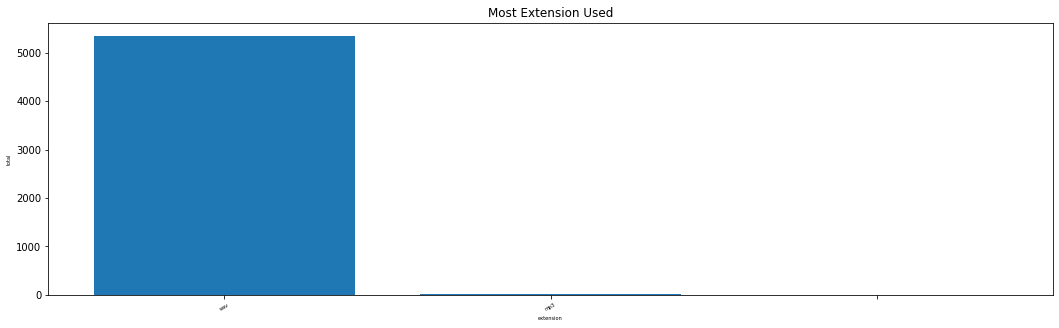

<Figure size 1440x1440 with 0 Axes>

In [14]:
def mostExtensionUsed():
    df = pd.read_sql_query("\
    SELECT s.extension, count(s.extension) as total \
     FROM fato as f INNER JOIN sample as s on f.id_sample = s.id_sample LEFT JOIN tag as t on f.id_tag = t.id_tag \
     GROUP BY s.extension \
     Order By total DESC", conn)
    return df
df = mostExtensionUsed().head()
plotBarGraph(df, df.extension, df.total, 'extension', 'total', 'Most Extension Used', 'mostExtensionUsed.csv')

In [ ]:
def mostDiskUsed():
    df = pd.read_sql_query("\
    SELECT s.disk, count(s.disk) as total \
     FROM fato as f INNER JOIN sample as s on f.id_sample = s.id_sample LEFT JOIN tag as t on f.id_tag = t.id_tag \
     GROUP BY s.disk \
     Order By total DESC", conn)
    return df
df = mostDiskUsed().head()
plotBarGraph(df, df.disk, df.total, 'disk', 'total', 'Most Disk Used', 'mostDiskUsed.csv')

In [15]:
#Valor medio dos loves
def avgLove():
    cur = conn.cursor()
    cur.execute(" SELECT avg(love) as avg_love FROM fato WHERE  love IS NOT NULL")
    row = cur.fetchall()
    return row[0][0]
    
avgLove()

50.5730510105871

In [42]:
def distLove():
    cur = conn.cursor()
    cur.execute("\
    SELECT f.love, count(f.love) as qtd \
    FROM fato as f LEFT JOIN tag as t on f.id_tag = t.id_tag \
	left join sample as s on f.id_sample = s.id_sample \
	WHERE f.love IS NOT NULL \
	group by f.love\
    ORDER by f.love DESC")
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns = ['love','count'])

df = distLove().head(10)
#plotBarGraph(df, df.love, df.count, 'love', 'count', 'DistLove', 'distLove.csv')

In [43]:
#BPM por genero
def distCountGenreBpm():
    cur = conn.cursor()
    cur.execute("select id_tag from tag")
    rowsTag = cur.fetchall()
    cur.execute("\
    SELECT s.genre, s.bpm, count(s.bpm) as count_genre_bpm from fato as f inner join sample as s on f.id_sample = s.id_sample\
    GROUP BY s.genre, s.bpm \
    ORDER BY s.genre ASC, count_genre_bpm DESC")
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns = ['genre','bpm', 'count_genre_bpm'])
df = distCountGenreBpm()
saveTableCsv(df, 'distCountGenreBpm')
df = distCountGenreBpm()
df.head()

,genre,bpm,count_genre_bpm
0,None,74.0,1
1,None,NaN,0
2,Bass House,78.0,10
3,Bass House,212.0,9
4,Bass House,232.0,8


In [44]:
#BPM por genero
def distCountBpmGenre():
    cur = conn.cursor()
    cur.execute("select id_tag from tag")
    rowsTag = cur.fetchall()
    cur.execute("\
    SELECT s.bpm, s.genre, count(s.genre) as count_bpm_genre from fato as f inner join sample as s on f.id_sample = s.id_sample \
    GROUP BY s.bpm, s.genre\
    ORDER BY s.BPM ASC, count_bpm_genre DESC")
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns = ['genre','bpm', 'count_genre_bpm'])
df = distCountBpmGenre()
saveTableCsv(df, 'distCountBpmGenre')
distCountBpmGenre().head()

,genre,bpm,count_genre_bpm
0,NaN,None,0
1,40.0,Tech House,5
2,40.0,Electro House,4
3,40.0,Blues,3
4,40.0,Rock,3


In [45]:
#Qtd Samples por Key
def keyDist():
    cur = conn.cursor()
    rowsTag = cur.fetchall()
    cur.execute("\
    SELECT key, count(key) as count_key from sample \
    GROUP BY key \
    ORDER BY count_key Desc")
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns = ['key', 'count_key'])
df = keyDist()
saveTableCsv(df, 'keyDist')
keyDist().head()

,key,count_key
0,B,70
1,C,66
2,Bmin,63
3,A#,60
4,Emin,59


In [46]:
#As tags mais associadas a sample
def mostUsedTag():
    cur = conn.cursor()
    rowsTag = cur.fetchall()
    cur.execute("\
    Select t.name, count(t.id_tag) as count_tag \
    from tag as t inner join fato as f on t.id_tag = f.id_tag \
    group by t.id_tag \
    order by count_tag DESC")
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns = ['key', 'total'])
df = mostUsedTag()
saveTableCsv(df, 'mostUsedTag')
mostUsedTag().head()

,key,total
0,Electric,787
1,Bass,405
2,Guitar,380
3,Drums,376
4,Key->Clavinet,20


In [47]:
#BPM por tag
def bpmByTag():
    cur = conn.cursor()
    rowsTag = cur.fetchall()
    cur.execute("\
    Select s.bpm, t.name, count(t.id_tag) as count_tag \
    from fato as f inner join sample as s on f.id_sample = s.id_sample \
    inner join tag as t on f.id_tag = t.id_tag \
    group by s.bpm, t.id_tag \
    order by bpm ASC, count_tag DESC")
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns = ['bpm', 'tag_name', 'total'])
df = bpmByTag()
saveTableCsv(df, 'bpmByTag')
bpmByTag().head()

,bpm,tag_name,total
0,NaN,Bass,1
1,NaN,Ambience,1
2,NaN,Acoustic,1
3,NaN,Arp,1
4,NaN,Brass->Stabs,1


In [48]:
#genero por tag
def genreByTag():
    cur = conn.cursor()
    rowsTag = cur.fetchall()
    cur.execute("\
    Select s.genre, t.name, count(t.id_tag) as count_tag \
    from fato as f inner join sample as s on f.id_sample = s.id_sample \
    inner join tag as t on f.id_tag = t.id_tag \
    group by s.genre, t.id_tag \
    order by genre ASC, count_tag DESC")
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns = ['genre', 'tag_name', 'total'])
df = genreByTag()
saveTableCsv(df, 'genreByTag')
genreByTag().head()

,genre,tag_name,total
0,None,Bass,1
1,None,Ambience,1
2,None,Acoustic,1
3,None,Arp,1
4,None,Brass->Stabs,1


In [49]:
#Key por tag
def keyByTag():
    cur = conn.cursor()
    rowsTag = cur.fetchall()
    cur.execute("\
    Select s.key, t.name, count(t.id_tag) as count_tag \
    from fato as f inner join sample as s on f.id_sample = s.id_sample \
    inner join tag as t on f.id_tag = t.id_tag \
    group by s.key, t.id_tag \
    order by key ASC, count_tag DESC")
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns = ['key', 'tag_name', 'total'])
df = keyByTag()
saveTableCsv(df, 'keyByTag')
keyByTag().head()

,key,tag_name,total
0,None,Ambience,1
1,None,Acoustic,1
2,None,Arp,1
3,None,Brass->Stabs,1
4,None,String->Ensemble,1


In [50]:
#Tags mais love
def loveMostByTag():
    cur = conn.cursor()
    cur.execute("\
    Select f.love, t.name, count(t.id_tag) as count_tag \
    from fato as f inner join sample as s on f.id_sample = s.id_sample \
    inner join tag as t on f.id_tag = t.id_tag \
    group by f.love, t.id_tag \
    order by f.love DESC, count_tag DESC")
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns = ['love', 'tag_name', 'total'])
df = loveMostByTag()
saveTableCsv(df, 'loveMostByTag')
loveMostByTag().head()

,love,tag_name,total
0,100.0,Electric,8
1,100.0,Drums,5
2,100.0,Guitar,4
3,100.0,Bass,3
4,100.0,CinematicFX->Warfare,2


In [51]:
#Genero mais love
def loveMostByGenre():
    cur = conn.cursor()
    cur.execute("\
    Select f.love, s.genre, count(s.genre) as count_tag \
    from fato as f inner join sample as s on f.id_sample = s.id_sample \
    inner join tag as t on f.id_tag = t.id_tag \
    group by f.love, s.genre \
    order by f.love DESC, count_tag DESC")
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns = ['love', 'tag_name', 'total'])
df = loveMostByGenre()
saveTableCsv(df, 'loveMostByGenre')
loveMostByGenre().head()

,love,tag_name,total
0,100.0,Jazz,4
1,100.0,Deep House,3
2,100.0,Other Genre,3
3,100.0,Pop,3
4,100.0,Vintage Breaks,3


In [55]:
#Bpm mais love
def loveMostByBpm():
    cur = conn.cursor()
    cur.execute("\
    Select f.love, s.bpm, count(s.bpm) as count_tag \
    from fato as f inner join sample as s on f.id_sample = s.id_sample \
    inner join tag as t on f.id_tag = t.id_tag \
    group by f.love, s.bpm \
    order by f.love DESC, count_tag DESC, s.bpm DESC")
    rows = cur.fetchall()
    return pd.DataFrame(rows, columns = ['love', 'tag_name', 'total'])
df = loveMostByBpm()
saveTableCsv(df, 'loveMostByBpm')
loveMostByBpm().head()


,love,tag_name,total
0,100.0,176.0,2
1,100.0,136.0,2
2,100.0,102.0,2
3,100.0,246.0,1
4,100.0,232.0,1


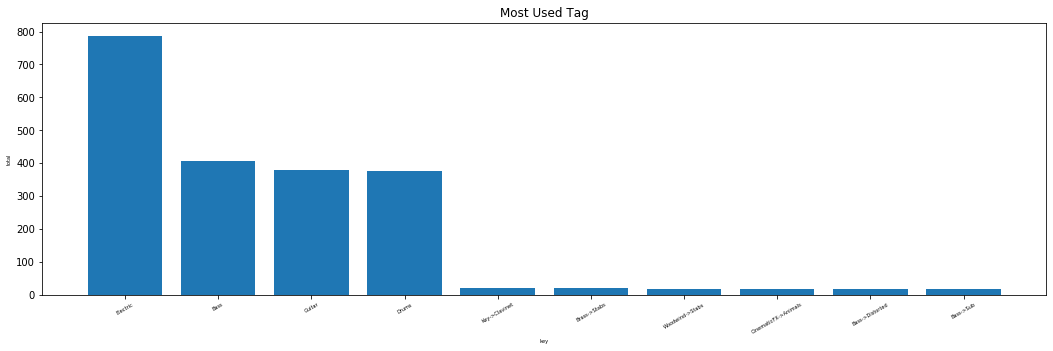

<Figure size 1440x1440 with 0 Axes>

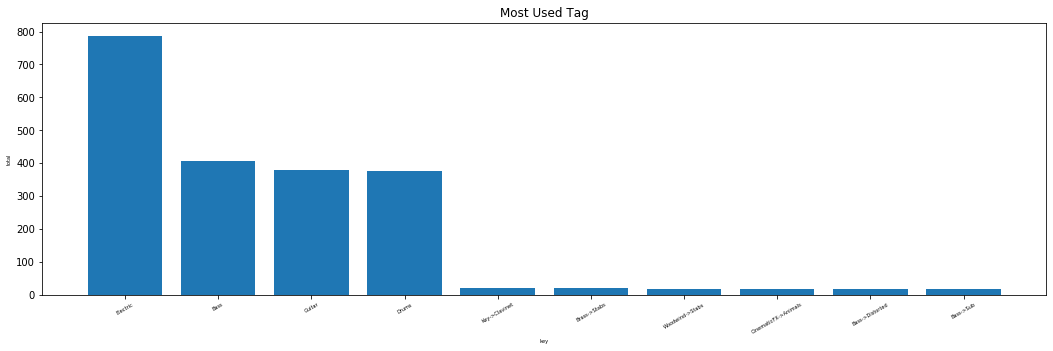

<Figure size 1440x1440 with 0 Axes>

In [56]:
def plotBarGraph(df, df_x, df_y, x_label, y_label, graph_title, file_name):
    # this is for plotting purpose
    fig, ax = plt.subplots(figsize=(18,5))
    index = np.arange(len(df_x))
    plt.bar(df_x, df_y)
    plt.xlabel(x_label, fontsize=5)
    plt.ylabel(y_label, fontsize=5)
    plt.xticks(index, fontsize=5, rotation=30)
    plt.title(graph_title)
    plt.figure(figsize=(20,20))
    fig.savefig("reportPic/teste", bbox_inches='tight',pad_inches=0.1)

    plt.show()
    
    df.to_csv('reportPic/' + file_name, index = None, header=True)
    return
df = mostUsedTag().head(10)
plotBarGraph(df, df.key, df.total, 'key', 'total', 'Most Used Tag', 'teste.csv')

df = mostUsedTag().head(10)
plotBarGraph(df, df.key, df.total, 'key', 'total', 'Most Used Tag', 'teste.csv')